<a href="https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JoaoLages/diffusers-interpret/blob/main/notebooks/stable_diffusion_img2img_example.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stable Diffusion - Img2Img 🎨 

This notebook shows an example of how to run `diffusers_interpret.StableDiffusionImg2ImgPipelineExplainer` to explain `diffusers.StableDiffusionImg2ImgPipeline`.

In [1]:
!nvidia-smi -L # enable GPU on Colab
!pip install -U diffusers-interpret
!pip install matplotlib==3.1.3

### 0 - Login in HuggingFace's Hub

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

from huggingface_hub import notebook_login
notebook_login()

### 1 - Initialize `StableDiffusionImg2ImgPipeline` normally

In [3]:
# make sure you're logged in by running the previous cell or `huggingface-cli login`
import torch
from contextlib import nullcontext
import requests
from PIL import Image
from io import BytesIO

from diffusers import StableDiffusionImg2ImgPipeline


device = 'cuda' if torch.cuda.is_available() else 'cpu'

pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4", 
    use_auth_token=True,
    
    # FP16 is not working for 'cpu'
    revision='fp16' if device != 'cpu' else None,
    torch_dtype=torch.float16 if device != 'cpu' else None
).to(device)
pipe.enable_attention_slicing() # comment this line if you wish to deactivate this option

{'trained_betas'} was not found in config. Values will be initialized to default values.


### 2 - Pass `StableDiffusionImg2ImgPipeline` to `StableDiffusionImg2ImgPipelineExplainer`

In [4]:
from diffusers_interpret import StableDiffusionImg2ImgPipelineExplainer

explainer = StableDiffusionImg2ImgPipelineExplainer(pipe, gradient_checkpointing=True)

### 3 - Generate an image with the `StableDiffusionImg2ImgPipelineExplainer` object

Note that the `explainer()` method accepts all the arguments that `pipe()` accepts. 

We also pass a `generator` argument so that we get a deterministic output.

In [5]:
prompt = "A fantasy landscape, trending on artstation"

# let's download an initial image
url = "https://raw.githubusercontent.com/CompVis/stable-diffusion/main/assets/stable-samples/img2img/sketch-mountains-input.jpg"

response = requests.get(url)
init_image = Image.open(BytesIO(response.content)).convert("RGB")
init_image = init_image.resize((448, 448))

generator = torch.Generator(device).manual_seed(42)
with torch.autocast('cuda') if device == 'cuda' else nullcontext():
    output = explainer(
        prompt=prompt, init_image=init_image, strength=0.75, guidance_scale=7.5, generator=generator
    )

  0%|          | 0/38 [00:00<?, ?it/s]

Calculating token and image pixel attributions... Done!


In [6]:
# Final image
output.image

#### 3.1 - Input Saliency Maps

It is now possible to visualize the computed pixel attributions in a saliency map

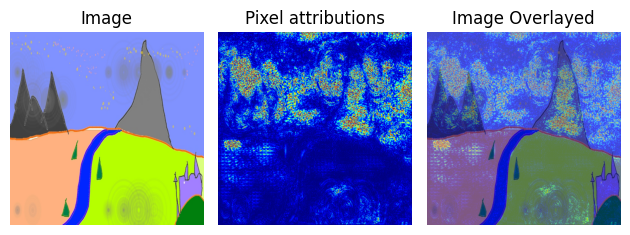

In [7]:
output.input_saliency_map.show(cmap='jet', image_weight=0.5)

Or access the pixel attributions directly

In [8]:
output.pixel_attributions.shape

(448, 448)

In [9]:
output.pixel_attributions

array([[ 2.4589844 ,  1.7451172 ,  0.99121094, ...,  3.6894531 ,
         3.1796875 ,  5.546875  ],
       [ 2.6777344 , 11.3671875 , 15.40625   , ..., 10.9765625 ,
        11.1015625 , 19.15625   ],
       [ 2.78125   ,  1.7119141 ,  9.3828125 , ..., 65.5625    ,
        56.0625    , 35.375     ],
       ...,
       [ 2.609375  ,  3.203125  ,  4.9140625 , ...,  7.8359375 ,
         9.25      ,  7.1132812 ],
       [ 1.1943359 ,  1.5488281 ,  2.8945312 , ..., 17.375     ,
        21.21875   , 14.0546875 ],
       [ 0.76708984,  1.7314453 ,  0.9614258 , ..., 20.15625   ,
         9.953125  ,  2.9570312 ]], dtype=float32)

Or their normalized version

In [10]:
output.normalized_pixel_attributions

array([[2.24566611e-05, 1.59372739e-05, 9.05222805e-06, ...,
        3.36939120e-05, 2.90384778e-05, 5.06568031e-05],
       [2.44543935e-05, 1.03810773e-04, 1.40697492e-04, ...,
        1.00243393e-04, 1.01384954e-04, 1.74944347e-04],
       [2.53997478e-05, 1.56340448e-05, 8.56884799e-05, ...,
        5.98749146e-04, 5.11990453e-04, 3.23061977e-04],
       ...,
       [2.38301036e-05, 2.92525219e-05, 4.48776482e-05, ...,
        7.15616552e-05, 8.44755705e-05, 6.49619979e-05],
       [1.09072662e-05, 1.41446635e-05, 2.64342907e-05, ...,
        1.58677081e-04, 1.93780128e-04, 1.28354353e-04],
       [7.00544342e-06, 1.58124130e-05, 8.78021547e-06, ...,
        1.84076838e-04, 9.08968577e-05, 2.70050714e-05]], dtype=float32)

#### 3.2 - You still have access to all the features that exist in `StableDiffusionPipelineExplainer`

Here are some examples below. Find out more features in [this notebook](https://colab.research.google.com/github/JoaoLages/diffusers-interpret/blob/main/notebooks/stable_diffusion_example_colab.ipynb).

In [11]:
# (token, attribution_percentage)
output.normalized_token_attributions

[('a', 8.994),
 ('fantasy', 18.431),
 ('landscape', 20.259),
 (',', 9.152),
 ('trending', 3.477),
 ('on', 5.584),
 ('art', 8.356),
 ('station', 25.748)]

In [12]:
# Google Colab does not render the IFrame from the code below, only works locally on your Jupyter Notebook.
#output.all_images_during_generation.show(width="100%", height="400px")

# but we can see the GIF!
output.all_images_during_generation.gif(file_name="diffusion_process.gif", duration=400)